# Librerías


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from arima import (
    sarima_rolling_training_rolling_prediction,
    plot_arima,
)
from sklearn.metrics import root_mean_squared_error  # type: ignore
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima

## Leemos la data


In [2]:
train_df = pd.read_parquet("../../../data/time_series/train_df.parquet").asfreq("D")
validation_df = pd.read_parquet(
    "../../../data/time_series/validation_df.parquet"
).asfreq("D")
test_df = pd.read_parquet("../../../data/time_series/test_df.parquet").asfreq("D")

In [3]:
train_and_validation_df = pd.concat([train_df, validation_df])
df = pd.concat([train_df, validation_df, test_df])

# AUTO SARIMA

Primero vamos a encontrar el modelo ARIMA óptimo para la serie de tiempo. Para esto vamos a utilizar la función auto_arima de la librería pmdarima.


In [4]:
auto_sarima_model = auto_arima(
    train_and_validation_df["gap"],
    max_p=10,
    m=7,
    maxiter=500,
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,
    out_of_sample_size=len(validation_df),
)

# Resumen del modelo
print(auto_sarima_model.summary())

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=99887.366, Time=0.36 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=99796.961, Time=3.73 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=99752.329, Time=11.00 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=99777.450, Time=2.65 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=39.38 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=95.03 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=99728.936, Time=12.36 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=83.29 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=118.56 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=98498.736, Time=0.65 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=98273.821, Time=15.07 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=98217.446, Time=20.54 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=98224.637, Time=12.61 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=80.33 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(2,0,0)[

In [5]:
arima_order = auto_sarima_model.get_params().get("order")
seasonal_order = auto_sarima_model.get_params().get("seasonal_order")
print(f"AUTO SARIMA ARIMA order: {arima_order}")
print(f"AUTO SARIMA Seasonal order: {seasonal_order}")

AUTO SARIMA ARIMA order: (2, 1, 1)
AUTO SARIMA Seasonal order: (2, 0, 0, 7)


# Predicciones


In [6]:
predictions = auto_sarima_model.predict(len(test_df["gap"]))

## Grafica de resultados


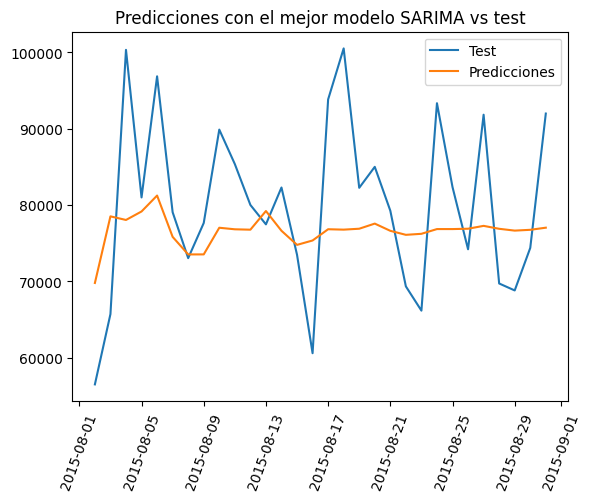

In [7]:
plt.plot(test_df["gap"].index, test_df["gap"], label="Test")
plt.plot(test_df["gap"].index, predictions, label="Predicciones")
plt.title("Predicciones con el mejor modelo SARIMA vs test")
plt.legend()
plt.xticks(rotation=70)
plt.show()

In [8]:
rmse = root_mean_squared_error(test_df["gap"], predictions)
mape = mean_absolute_percentage_error(test_df["gap"], predictions)
mae = mean_absolute_error(test_df["gap"], predictions)

In [9]:
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"MAE: {mae}")

RMSE: 10911.66967926672
MAPE: 0.10919892877990418
MAE: 8880.745543660594


# Best model with rolling training rolling prediction


In [10]:
(
    mape_sarima_rolling,
    rmse_sarima_rolling,
    [predictions_sarima_rolling, values_sarima_rolling],
) = sarima_rolling_training_rolling_prediction(
    train_df=train_and_validation_df,
    test_df=test_df,
    arima_order=arima_order,
    seasonal_order=seasonal_order,
    column="gap",
)

SARIMA Order: (2, 1, 1)
Seasonal Order: (2, 0, 0, 7)
RMSE: 10511.9626753209
MAPE: 10.67%
MAE: 8561.307768346871


In [11]:
plot_arima(
    test_df,
    values_sarima_rolling,
    predictions_sarima_rolling,
    title="Test vs Predicciones usando Rolling Training Rolling Prediction",
)